#### dependencies

In [ ]:
!pip install EMD-signal
!pip install prophet
!pip install xlrd ==2.0.1
!pip install pmdarima

In [ ]:
# !pip freeze > requirements.txt
# !pip uninstall -r requirements.txt -y

#### imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error , mean_squared_error, mean_absolute_error

In [ ]:
from PyEMD import EMD
from PyEMD import CEEMDAN
from prophet import Prophet
from pmdarima import auto_arima

# **3.Total Energy**

## 3.0 read data

In [ ]:
tot_df = pd.read_csv("/Datasets/total-renewable.csv")
tot_df.head()

,y
0,162.518
1,153.759
2,156.994
3,151.019
4,154.153


In [ ]:
tot_df.describe()

,y
count,156.000000
mean,187.860513
std,21.576694
min,148.396000
25%,165.342250
50%,196.388000
75%,206.672750
max,234.113000


In [ ]:
tot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       156 non-null    float64
dtypes: float64(1)
memory usage: 1.3 KB


<Axes: >

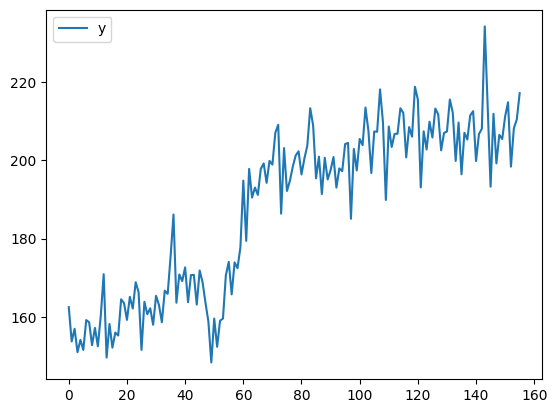

In [ ]:
tot_df.plot()

In [ ]:
tot_ds = pd.date_range(start="2005-01-01", periods = len(tot_df), freq="MS")
tot_df["ds"]=tot_ds

In [ ]:
tot_train_set = tot_df[:-12]
tot_test_set = tot_df[-12:]

## 3.1 Prophet

In [ ]:
tot_prophet = Prophet(seasonality_mode="multiplicative")
tot_prophet.fit(tot_train_set)
tot_future = tot_prophet.make_future_dataframe(len(tot_test_set), freq="MS")
tot_forecast = tot_prophet.predict(tot_future)

## 3.2 Prophet-EMD

### decomposition

In [ ]:
emd = EMD(spline_kind = 'akima')
tot_imfs = emd.emd(tot_train_set.y.values)

In [ ]:
tot_imfs.shape

(5, 144)

### +Prophet

In [ ]:
tot_forecast_temp=pd.DataFrame()
tot_forecast_temp["ds"] = tot_ds
tot_forecast_temp["yhat"] = 0

for imf in tot_imfs:
  temp = pd.DataFrame(imf)
  temp['ds'] = tot_ds[:len(tot_train_set)]
  temp.columns = [ 'y', 'ds']
  model = Prophet(seasonality_mode="additive")
  model.fit(temp)
  future = model.make_future_dataframe(12, freq="MS")
  tot_forecast = model.predict(future)
  tot_forecast_temp["yhat"] += tot_forecast['yhat']

## 3.3 Prophet-CEEMDAN

### decomposition

In [ ]:
cmd = CEEMDAN(spline_kind = 'akima')
tot_cmd_imfs = cmd.ceemdan(tot_train_set.y.values)

In [ ]:
tot_cmd_imfs.shape

(6, 144)

### +Prophet

In [ ]:
tot_cmd_forecast_temp=pd.DataFrame()
tot_cmd_forecast_temp["ds"] = tot_ds
tot_cmd_forecast_temp["yhat"] = 0

for imf in tot_cmd_imfs:
  temp = pd.DataFrame(imf)
  temp['ds'] = tot_ds[:len(tot_train_set)]
  temp.columns = [ 'y', 'ds']
  model = Prophet(seasonality_mode="multiplicative")
  model.fit(temp)
  future = model.make_future_dataframe(12, freq="MS")
  tot_cmd_forecast = model.predict(future)
  tot_cmd_forecast_temp["yhat"] += tot_cmd_forecast['yhat']

## 3.4 Prophet-ICEEMDAN

### import imfs

In [ ]:
total_renew_ic_imfs = pd.read_csv("/ICEEMDAN-IMFS/IMF_total_renewable.csv", header = None)
total_renew_ic_imfs = total_renew_ic_imfs.to_numpy()
total_renew_ic_imfs.shape

(6, 144)

### +Prophet

In [ ]:
total_renew_ic_temp = pd.DataFrame()
total_renew_ic_temp["ds"] = tot_ds
total_renew_ic_temp["yhat"] = 0

for imf in total_renew_ic_imfs:
  temp = pd.DataFrame(imf)
  temp['ds'] = tot_ds[:len(tot_train_set)]
  temp.columns = [ 'y', 'ds']
  model = Prophet(seasonality_mode="multiplicative")
  model.fit(temp)
  future = model.make_future_dataframe(12, freq="MS")
  tot_ic_forecast = model.predict(future)
  total_renew_ic_temp["yhat"] += tot_ic_forecast['yhat']


## 3.5 SARIMAX

In [ ]:
temp = tot_train_set.copy()
temp.index = tot_train_set.ds
temp.drop("ds", axis=1,inplace=True)
temp

In [ ]:
tot_model_arima = auto_arima(temp , m=12, stationary=True)
tot_forecast_arima = tot_model_arima.predict(len(tot_test_set))

In [ ]:
tot_model_arima.summary()

# plots

## test set chart

#### data

In [ ]:
tot_test = 12
tot_df = pd.read_csv("/Datasets/total-renewable.csv")
tot_ds = pd.date_range(start="2005-01-01", periods = len(tot_df), freq="MS")
tot_df["ds"]=tot_ds

In [ ]:
tot_df_p = pd.read_excel("/Forecasts/total-renewable/tot_prophet.xlsx")
tot_df_p = tot_df_p[['ds', 'yhat']]

In [ ]:
tot_df_ep = pd.read_excel("/Forecasts/total-renewable/tot_prophet_EMD.xlsx")
tot_df_ep = tot_df_ep[['ds', 'yhat']]

In [ ]:
tot_df_cp = pd.read_excel("/Forecasts/total-renewable/tot_prophet_ceemdan.xlsx")
tot_df_cp = tot_df_cp[['ds', 'yhat']]

In [ ]:
tot_df_icp = pd.read_excel("/Forecasts/total-renewable/tot_prophet_ICEEMDAN.xlsx")
tot_df_icp = tot_df_icp[['ds', 'yhat']]

In [ ]:
tot_df_s = pd.read_excel("/Forecasts/total-renewable/tot_sarimax.xlsx")
tot_df_s = tot_df_s[0]
tot_df_s.columns=['yhat']

In [ ]:
plotting_test(tot_df, tot_df_p, tot_df_ep, tot_df_cp, tot_df_icp, tot_df_s, "Total energy consumption", "Month", "total_test_func.jpg",12)

## bar plot

In [ ]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] += ['Times Roman']
width = 0.1

def bar_plotter(values, title, name, tick):
  xticks = ['MAPE']
  multiplier = 0
  x = np.arange(len(xticks))

  fig, ax = plt.subplots(layout="constrained", figsize=(10,6))

  for i,j in values.items():
    offset = width * multiplier
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] += ['Times Roman']
    rects = ax.bar(x + offset, j, width, label = i)
    ax.bar_label(rects, padding=4, fontweight="bold", fontsize=13)
    multiplier+=1

  plt.legend(fontsize=13, loc="upper left")

  ax.set_xticks(x+tick, xticks, fontsize=14, fontweight="bold")
  plt.yticks(fontweight='bold', fontsize=14)

  ceil = round(max(list(values.values())) + 0.2*(max(list(values.values()))))

  plt.ylim(0, ceil)

  plt.grid(axis='y')
  ax.set_axisbelow(True)
  plt.margins(2*(1-len(values)/10), 0)
  plt.savefig(f"{name}.jpg", dpi=1200)

round


In [ ]:
def rounder(dictionary):
  for i,j in dictionary.items():
    dictionary[i] = round(j, 2)
  return(dictionary)

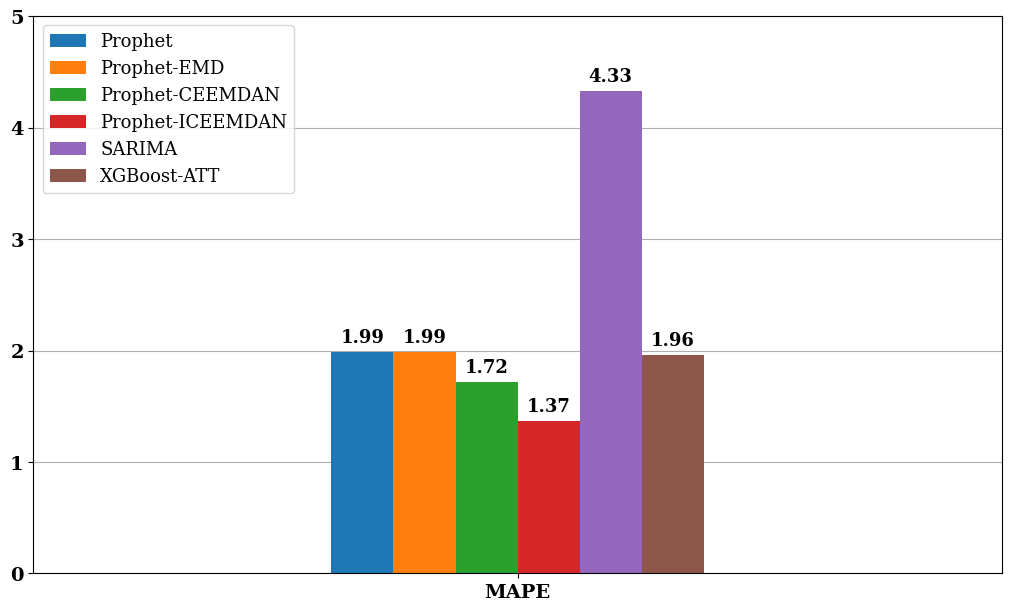

In [ ]:
tot_values = {
    # method : (MAPE)
    "Prophet":(1.994),
    "Prophet-EMD": (1.992),
    "Prophet-CEEMDAN":(1.718),
    "Prophet-ICEEMDAN":(1.37),
    "SARIMA":(4.332),
    "XGBoost-ATT": (1.96)
}

bar_plotter(rounder(tot_values), "Total Renewable energy", "tot_comparison_plot", 0.25)